In [ ]:
import pandas as pd

df = pd.read_csv("accepted_2007_to_2018Q4.csv")

df.head()

#We will check the default column and understand how many defaults are there

df['loan_status'].value_counts()


bad_status = ['Charged Off', 'Default', 'Late (31-120 days)']

df['default_flag'] = df['loan_status'].isin(bad_status).astype(int)

df[['loan_status', 'default_flag']].head(10)




/tmp/ipython-input-583089492.py:3: DtypeWarning: Columns (0,19,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("accepted_2007_to_2018Q4.csv")


,loan_status,default_flag
0,Fully Paid,0
1,Fully Paid,0
2,Fully Paid,0
3,Current,0
4,Fully Paid,0
5,Fully Paid,0
6,Fully Paid,0
7,Fully Paid,0
8,Fully Paid,0
9,Fully Paid,0


In [ ]:
finished_status = ['Fully Paid', 'Charged Off', 'Default', 'Late (31-120 days)']

df_finished = df[df['loan_status'].isin(finished_status)]

df_finished['loan_status'].value_counts()


,count
loan_status,
Fully Paid,719345
Charged Off,182667
Late (31-120 days),12908
Default,23


In [ ]:
default_rate = df_finished['default_flag'].mean()

default_rate


np.float64(0.21378162355469138)

In [ ]:
features = [
    'loan_amnt',
    'int_rate',
    'term',
    'installment',
    'grade',
    'annual_inc'
]

df_finished[features].head()

df_model = df_finished[features + ['default_flag']].copy()

df_model.head()

df_model['int_rate'].dtype

df_model['term'] = df_model['term'].str.replace(' months', '').astype(int)

df_model = df_model.dropna()

df_model.shape





(914943, 7)

In [ ]:
from sklearn.model_selection import train_test_split

X = df_model[features]
y = df_model['default_flag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_train.shape, X_test.shape


((640460, 6), (274483, 6))

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)

model.fit(X_train, y_train)


ValueError: could not convert string to float: 'A'

In [ ]:
grade_mapping = {
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7
}

df_model['grade_num'] = df_model['grade'].map(grade_mapping)

df_model[['grade', 'grade_num']].head()

features_updated = [
    'loan_amnt',
    'int_rate',
    'term',
    'installment',
    'grade_num',
    'annual_inc'
]

X = df_model[features_updated]
y = df_model['default_flag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_train.shape


(640460, 6)

In [ ]:
model = LogisticRegression(max_iter=1000)

model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [ ]:
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_pred_proba[:10]


array([0.13945708, 0.2626679 , 0.1950971 , 0.48344944, 0.15329321,
       0.12077264, 0.15864276, 0.07947731, 0.07854712, 0.10201187])

In [ ]:
#AUC calculation
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, y_pred_proba)

auc


np.float64(0.7051341485396518)

In [ ]:
#We will put probabilites in bands

import pandas as pd

results = X_test.copy()
results['actual'] = y_test
results['pd_score'] = y_pred_proba

def risk_band(pd):
    if pd < 0.3:
        return 'Low Risk'
    elif pd < 0.6:
        return 'Medium Risk'
    else:
        return 'High Risk'

results['risk_band'] = results['pd_score'].apply(risk_band)

results[['pd_score', 'risk_band']].head()


,pd_score,risk_band
961567,0.139457,Low Risk
1133972,0.262668,Low Risk
580820,0.195097,Low Risk
408324,0.483449,Medium Risk
128174,0.153293,Low Risk


In [ ]:
#valid Risk Seperation

results.groupby('risk_band')['actual'].mean()


,actual
risk_band,
High Risk,0.533019
Low Risk,0.165736
Medium Risk,0.404095


In [ ]:
#Confusion Matrix

from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))



[[210816   5081]
 [ 53465   5121]]
              precision    recall  f1-score   support

           0       0.80      0.98      0.88    215897
           1       0.50      0.09      0.15     58586

    accuracy                           0.79    274483
   macro avg       0.65      0.53      0.51    274483
weighted avg       0.73      0.79      0.72    274483



In [ ]:
y_prob = model.predict_proba(X_test)[:, 1]

y_pred_30 = (y_prob >= 0.30).astype(int)

confusion_matrix(y_test, y_pred_30)
print(classification_report(y_test, y_pred_30))


              precision    recall  f1-score   support

           0       0.83      0.86      0.85    215897
           1       0.41      0.37      0.39     58586

    accuracy                           0.75    274483
   macro avg       0.62      0.61      0.62    274483
weighted avg       0.74      0.75      0.75    274483



AUC: 0.7051341485396518


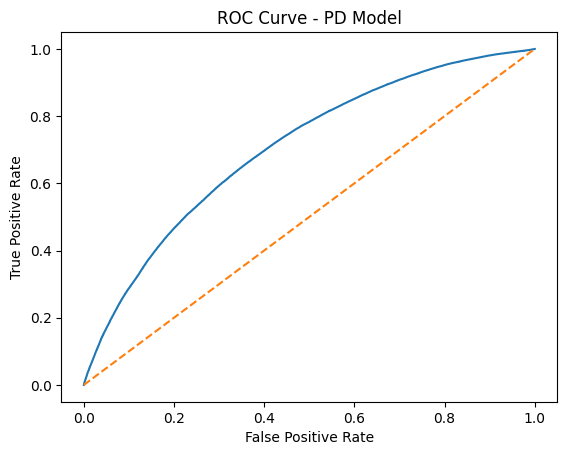

In [ ]:
#ROC Curve and AOC

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

auc = roc_auc_score(y_test, y_prob)
print("AUC:", auc)

fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - PD Model")
plt.show()
